In [27]:
from osgeo import gdal, gdalconst, gdal_array
from PIL import Image
import pylab as plt
import matplotlib.image as mpimg
import csv
import numpy as np
import geopandas as gpd
from sklearn.model_selection import KFold 
from sklearn import cross_validation
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import pandas as pd

#### Fix up satellite image as 3D array

In [4]:
# Read in the satellite image

inputfile = 'data/houston/h_small_2.tif'

dataset = gdal.Open(inputfile, gdal.GA_ReadOnly)

# How many bands does this image have?
num_bands = dataset.RasterCount
rows = dataset.RasterYSize
cols = dataset.RasterXSize
print('Number of bands in image: {n}'.format(n=num_bands))
print('Image size is: {r} rows x {c} columns'.format(r=rows, c=cols))

Number of bands in image: 12
Image size is: 1050 rows x 1784 columns


In [5]:
# Load it into an array called 'image'

# Initialize a 3d array -- size based on raster dimensions
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount))

# Allocate array using the first band's datatype
image_datatype = dataset.GetRasterBand(1).DataType

image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset

for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()

In [6]:
image = np.nan_to_num(image)

Band 4 of the satellite image: east-central Houston


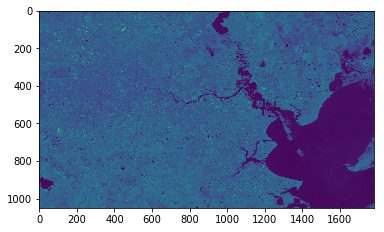

In [49]:
plt.imshow(image[:,:,4])
print("Band 4 of the satellite image: east-central Houston")

#### Fix up training image

In [8]:
# Read in Houston training image

resampled_input = 'data/houston/h_resampled_clips_trainin.tif'

houston_read = gdal.Open(resampled_input, gdal.GA_ReadOnly)

h_train = np.zeros((houston_read.RasterYSize, houston_read.RasterXSize),
               gdal_array.GDALTypeCodeToNumericTypeCode(houston_read.GetRasterBand(1).DataType))
h_train = houston_read.ReadAsArray()

#### Note, the classes are:
0: open water
1: developed high intensity
2: developed med intensity
3: developed low intensity
4: developed open space
5-10: barren, forest, pasture, crops, wetlands

We want to reclass as:

0: open water
1: developed high and med intensity
2: developed low intensity and developed open space
3: non-urban land

In [9]:
# Reclass the pixels in our new categories

h_train = np.nan_to_num(h_train)

category_dict = {0:4, 1:1, 2:2, 3:2, 4:3, 5:3, 6:4, 7:4, 8:4, 9:4, 10:4, 255:4}

h_train_cat = np.vectorize(category_dict.get)(h_train.reshape(-1,1))

# Reshape the categorized image to its proper x,y shape
h_train_cat=h_train_cat.reshape(h_train.shape)
print(h_train_cat.shape)

(1050, 1784)


In [10]:
# How many pixels for each category?

classes = np.unique(h_train_cat)
per_class=[]
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(h_train_cat == c).sum()))
    per_class.append((h_train_cat == c).sum())

Class 1 contains 324218 pixels
Class 2 contains 438295 pixels
Class 3 contains 479183 pixels
Class 4 contains 631504 pixels


Pixels per category


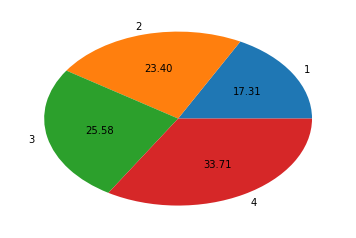

In [11]:
plt.pie(per_class,labels=classes,autopct='%.2f');
print("Pixels per category")

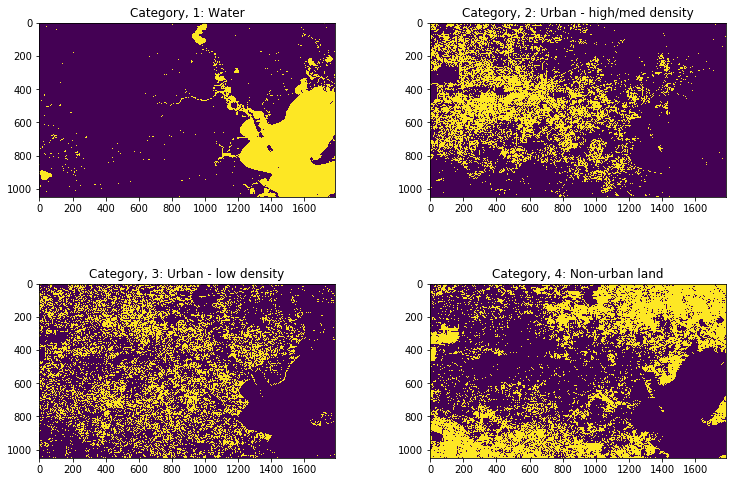

In [12]:
# Visualize categorized training image from its np array
fig, axs = plt.subplots(2,2, figsize=(14, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

titles=['1: Water','2: Urban - high/med density','3: Urban - low density',
      '4: Non-urban land']

for i in range(4):

    axs[i].imshow(h_train_cat==i+1)
    axs[i].set_title("Category, "+titles[i])

In [13]:
print('satellite: ',image.shape)
print("train: ",h_train_cat.shape)


('satellite: ', (1050, 1784, 12))
('train: ', (1050, 1784))


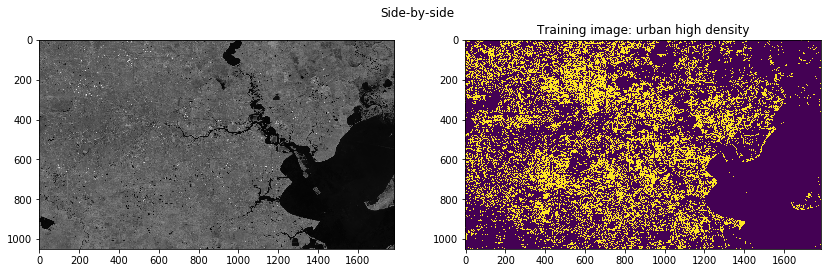

In [14]:
# Side-by-side plot

f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.imshow(image[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('Fourth band of satellite image')

ax2.imshow(h_train_cat==3)
plt.title('Training image: urban high density')

plt.suptitle("Satellite image next to training image");

#### Train random forest

In [15]:
# Create flattened X and y arrays

new_shape = (image.shape[0] * image.shape[1],9)
X = image[:, :, :9].reshape(new_shape)
Y = h_train_cat.reshape(-1,1)

print(X.shape,Y.shape)

((1873200, 9), (1873200, 1))


In [18]:
# Train random forest

rf = RandomForestClassifier(n_estimators=12)
rf = rf.fit(X, Y)

/nfshome/nj935/.conda/envs/remote_sensing/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [21]:
# Now predict for each pixel
class_pred_rf = rf.predict(X)

# Reshape our classification map
class_pred_rf = class_pred_rf.reshape(image[:, :, 0].shape)

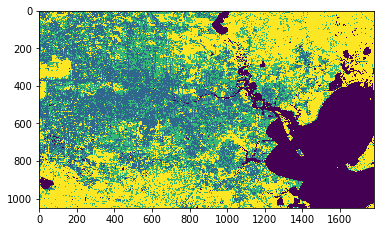

In [24]:
plt.imshow(class_pred_rf)

In [ ]:
# Plot the RF predictions of land use
fig, axs = plt.subplots(2,2, figsize=(14, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

titles=['1: Water','2: Urban - high/med density','3: Urban - low density',
      '4: Non-urban land']

for i in range(4):

    axs[i].imshow(class_pred_rf==i+1)
    axs[i].set_title("Category, "+titles[i])

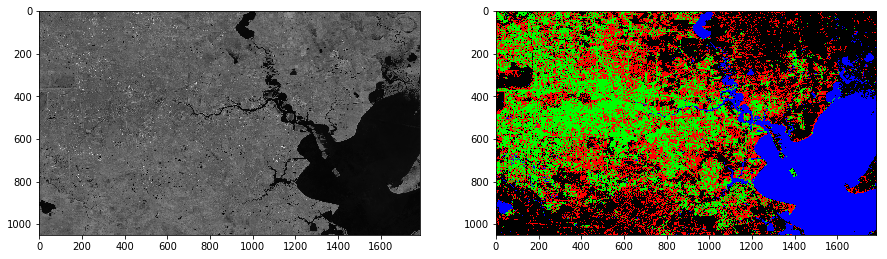

In [48]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(image, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_pred_rf.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # NA  
    (1, (0, 0, 255, 255)),  # Blue ## Urban 
    (2, (0, 255, 0, 255)),  #Green ##Park  
    (3, (255, 0, 0, 255)),  # Red ##Industrial
    (4, (0, 0, 0, 255)),  # NA # 160, 82, 45, 255
    (5, (0, 0, 0, 255))  # NA
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification')

# Now show the classmap next to the image
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121)
ax.imshow(image[:, :, 4], cmap=plt.cm.Greys_r)

ax = f.add_subplot(122)
#plt.subplot(122)
ax.imshow(class_pred_rf, cmap=cmap, interpolation='none')

######
#values = np.unique(class_pred_rf.ravel())
#colors = [ image.cmap(image.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
#dic = {0:'Urban Area', 1:'Parks', 2:'Industrial/Other Urabn'}
#patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=dic[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
#plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
######

plt.show()

#### Validation

In [41]:
Y.ravel()

array([3, 2, 3, ..., 4, 4, 4])

In [42]:
df = pd.DataFrame()
df['truth'] = Y.ravel()
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict       1       2       3       4      All
truth                                           
1        322819     306     153     940   324218
2           439  427660    8590    1606   438295
3           141   12507  456006   10529   479183
4           991    2229   11046  617238   631504
All      324390  442702  475795  630313  1873200
